In [2]:
# Importing necessary library
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import os
from scipy import signal
from stingray import lightcurve
import sys
from stingray import Bispectrum
import warnings
import csv
warnings.filterwarnings('ignore')
%matplotlib inline

c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\stingray\utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\stingray\utils.py:40: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


In [3]:
# Importing necessary library
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import os
from scipy import signal
from stingray import lightcurve
import sys
from stingray import Bispectrum
import warnings
import csv
warnings.filterwarnings('ignore')
%matplotlib inline

### Menghitung Matriks Cumulant orde ke-3

In [4]:
def calcCumulantOrde3(df_data, t, lag):
    # Compute the bispectrum of the signal
    lc = lightcurve.Lightcurve(t,df_data.T)
    bs = Bispectrum(lc, maxlag=lag)

    # Plot the bispectrum using contour plots
    # plt.contour(bs.freq, bs.freq, bs.bispec_mag)
    # plt.xlabel('f1')
    # plt.ylabel('f2')
    # plt.show()

    # # Plot the bispectrum using mesh plots
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # X, Y = np.meshgrid(bs.freq, bs.freq)
    # ax.plot_surface(X, Y, bs.bispec_mag)
    # ax.set_xlabel('f1')
    # ax.set_ylabel('f2')
    # ax.set_zlabel('Bispectrum')
    # plt.show()

    return bs

### Melakukan dekomposisi wavelet

In [93]:
def calcWaveletDec(bs):
    # Select wavelet and decomposition level
    wavelet = 'db4'
    level = 5

    # Deecompose signal
    coeffs = pywt.wavedec2(bs.cum3, wavelet, level=level)

    # print(coeffs)
    # Visualize
    
    cA5 = coeffs[0][np.triu(np.ones_like(coeffs[0], dtype=bool))]
    cD5 = np.ravel([coeffs[1][0], coeffs[1][1], coeffs[1][2]])
    cD4 = np.ravel([coeffs[2][0], coeffs[2][1], coeffs[2][2]])
    cD3 = np.ravel([coeffs[3][0], coeffs[3][1], coeffs[3][2]])
    cD2 = np.ravel([coeffs[4][0], coeffs[4][1], coeffs[4][2]])
    cD1 = np.ravel([coeffs[5][0], coeffs[5][1], coeffs[5][2]])
    
    coeff = [cA5,cD5,cD4,cD3,cD2,cD1]
    # fig, axs = plt.subplots(6)
    
    
    # axs[0].plot(cA5)
    # axs[0].set_title(f'Approximation - Level 5')
    # axs[1].plot(cD5)
    # axs[1].set_title(f'Detail - Level 5')
    # axs[2].plot(cD4)
    # axs[2].set_title(f'Detail - Level 4')
    # axs[3].plot(cD3)
    # axs[3].set_title(f'Detail - Level 3')
    # axs[4].plot(cD2)
    # axs[4].set_title(f'Detail - Level 2')
    # axs[5].plot(cD1)
    # axs[5].set_title(f'Detail - Level 1')
    # plt.show()

    return coeffs


### Menghitung energi relatif

In [29]:
def calcRelativeEnergy(coeffs, df_data):
    # Calculate relative wavelet energy
    energies = []
    for c in coeffs:
        energies.append(np.sum(np.square(c)))

    print(energies)

    decomp = ['A5', 'D1', 'D2', 'D3', 'D4', 'D5']

    temp = energies
    energies[1:6] = energies[-1:-6:-1]

    total_energy = np.sum(np.square(c))
    relative_energies = [e / total_energy for e in energies]

    # plt.plot(decomp, energies)
    # plt.xlabel('Dimension Number')
    # plt.ylabel('Wavelet Bispectrum Energy')
    # plt.show()

    # plt.plot(decomp, relative_energies)
    # plt.xlabel('Dimension Number')
    # plt.ylabel('Relative Wavelet Bispectrum Energy')
    # plt.show()

    return energies, relative_energies

### Persiapan data

In [7]:
# Define sampling frequency
fs = 256
t = np.arange(0, 1, 1/fs)

def get_csv_EEG(filename):
    # Load data from CSV
    data = np.loadtxt(filename, delimiter=",", skiprows=1, usecols=range(3,259))
    channel_name = np.loadtxt(filename, delimiter=",", skiprows=1, usecols=1, dtype='str', encoding='utf-8')
    
    df_data = pd.DataFrame(data.T, columns=channel_name)

    df_data = df_data.drop(columns=['X', 'Y', 'nd'])

    return df_data, df_data.columns


### Perhitungan RWB

In [8]:
def extract_feature(directory, lag):
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            des_dir = os.path.join(directory.replace('CSV', 'FEATURE')+"_" + str(lag),foldername).lower()
            files = os.listdir(folder)
            for filename in files:
                rel_path = os.path.join(directory, foldername, filename)
                if 'metadata' in filename.lower():
                    continue
                trial_number = filename.split('.')[0].split('_')[1]
                df_data, channel_name = get_csv_EEG(rel_path)
                RWB = []
                for channel in channel_name:
                    # y = df_data[channel]; # sinyal per channel
                    # N = len(y);
                    # z = y - np.mean(y);
                    # nsamp = len (y[0])
                    energies, relative_energies = calcRelativeEnergy(calcWaveletDec(calcCumulantOrde3(y, t, lag)), y)
                    for x in relative_energies:
                        RWB.append(x)
                des_file = foldername+'_'+ str(trial_number) + '_feature' +'.csv'
                if not os.path.exists(des_dir):
                    os.makedirs(des_dir)
                des_path = os.path.join(des_dir, des_file)
                with open(des_path, 'w') as file:
                    writer = csv.writer(file)
                    writer.writerow(RWB)
                # pd.DataFrame(RWB.T).to_csv(des_path, index=False)
        


In [24]:
def get_dummy(directory, lag):
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            des_dir = os.path.join(directory.replace('CSV', 'FEATURE')+"_" + str(lag),foldername).lower()
            files = os.listdir(folder)
            for filename in files:
                rel_path = os.path.join(directory, foldername, filename)
                if 'metadata' in filename.lower():
                    continue
                trial_number = filename.split('.')[0].split('_')[1]
                df_data, channel_name = get_csv_EEG(rel_path)
                RWB = []
                return df_data[channel_name[0]]
                # pd.DataFrame(RWB.T).to_csv(des_path, index=False)
        


### Main Program

66049
1


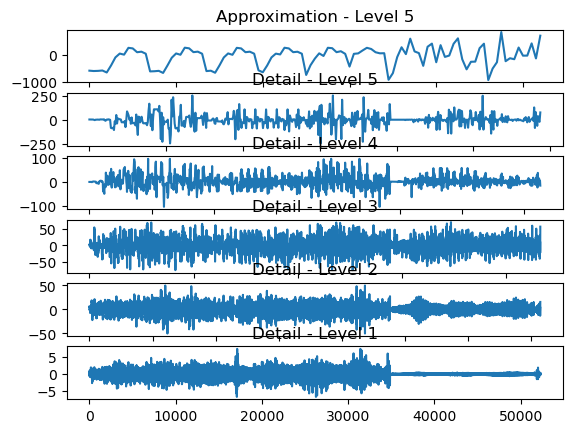

[23169237.097540967, 2387508.36471616, 887170.9687235847, 1954447.410497359, 1040598.3366357228, 37904.5946690756]


In [92]:
lag = 128
dummy = get_dummy('../SMNI_CMI_TEST_CSV', lag)
relative_energies = calcRelativeEnergy(calcWaveletDec(calcCumulantOrde3(dummy, t, lag)), dummy)
